In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import pandas as pd
import nibabel as nib
import torch
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as transforms

### **Data Preprocessing**
##### Tabular (CSV) Data - Clinical Information

Load and understand the datast

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/alzheimer analysis/OASIS-1 Demographic and Clinical Data/oasis_cross-sectional.xlsx")

In [ ]:
print(df.shape)  #(rows, columns)

(436, 12)


In [ ]:
df.sample(5)

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
262,OAS1_0290_MR1,M,R,83,3.0,2.0,26.0,0.5,1992,0.706,0.881,NaN
206,OAS1_0227_MR1,F,R,26,NaN,NaN,NaN,NaN,1288,0.777,1.362,NaN
208,OAS1_0229_MR1,F,R,55,3.0,3.0,30.0,0.0,1327,0.832,1.323,NaN
91,OAS1_0098_MR1,F,R,67,2.0,NaN,18.0,0.5,1653,0.693,1.062,NaN
104,OAS1_0112_MR1,F,R,69,5.0,2.0,29.0,0.0,1536,0.733,1.143,NaN


In [ ]:
df['Hand'].value_counts()

,count
Hand,
R,436


In [ ]:
df['CDR'].value_counts()

,count
CDR,
0.0,135
0.5,70
1.0,28
2.0,2


In [ ]:
df['Educ'].value_counts()

,count
Educ,
2.0,64
5.0,51
4.0,50
3.0,47
1.0,23


Handling missing values

In [ ]:
df.isnull().sum()

,0
ID,0
M/F,0
Hand,0
Age,0
Educ,201
SES,220
MMSE,201
CDR,201
eTIV,0
nWBV,0


In [ ]:
df_copy = df

In [ ]:
df_copy['SES'].value_counts()

,count
SES,
2.0,65
1.0,50
3.0,49
4.0,49
5.0,3


In [ ]:
df_copy['MMSE'].value_counts()

,count
MMSE,
30.0,69
29.0,52
28.0,29
27.0,18
26.0,17
23.0,10
22.0,7
20.0,7
21.0,6


***Delay*** isn't a direct feature for diagnosis or classification, and most values are missing, so best approach is to drop the Delay column.


***CDR*** values are categorical, with specific meaning:
0 = Normal, 0.5 = Very Mild Dementia, 1 = Mild Dementia, 2 = Moderate Dementia.

CDR is the target feature. Its values are categorical, with specific meaning.
Any in-between values are not medically valid.

It shouldn't be  imputed, because it will indroduce fake and misleading targets, since half of the dataset has a NaN value, it will bias the result.

If half of the dataset wasn't supposed to be dropped, then Educ, SES and MMSE would have been imputed with advanced imputation (probably KNN), because a lot of rows have missing columns.

In [ ]:
df_copy = df_copy.drop(columns=['Delay'])

In [ ]:
df_copy = df_copy.dropna(subset=['CDR'])
df_copy.isnull().sum()

,0
ID,0
M/F,0
Hand,0
Age,0
Educ,0
SES,19
MMSE,0
CDR,0
eTIV,0
nWBV,0


In [ ]:
df_copy['SES'].value_counts()

,count
SES,
2.0,65
1.0,50
3.0,49
4.0,49
5.0,3


In [ ]:
mode_value = df_copy['SES'].mode()[0]
df_copy['SES'].fillna(mode_value, inplace=True)

<ipython-input-19-c88f15ab6327>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['SES'].fillna(mode_value, inplace=True)


Missing values in the SES column (n=19) were imputed using the mode value (SES = 2.0), as SES is an ordinal categorical variable and 2.0 was the most frequent value in the dataset. Given the low number of missing entries, this approach minimizes distortion while preserving category distribution.

In [ ]:
df_copy.isnull().sum()

,0
ID,0
M/F,0
Hand,0
Age,0
Educ,0
SES,0
MMSE,0
CDR,0
eTIV,0
nWBV,0


#### Columns like 'Hand' and 'M/F' have labeled values (categorical), so they should be encoded.

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_copy['M/F'] = encoder.fit_transform(df_copy['M/F'])
df_copy['Hand'] = encoder.fit_transform(df_copy['Hand'])

### **Selecting Features and Target**
Correlation analysis and feature importance

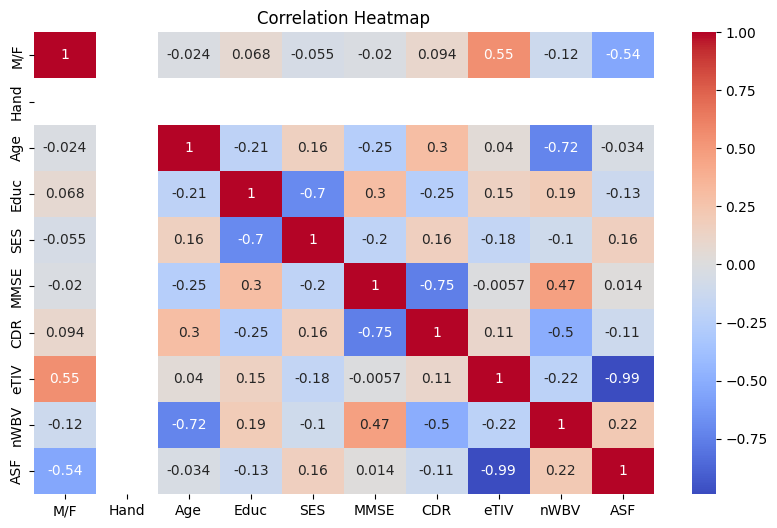

In [ ]:
df_corr = df_copy.drop(columns=['ID'])

plt.figure(figsize=(10,6))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
correlation_with_target = df_corr.corr()['CDR'].sort_values(ascending=False)
print(correlation_with_target)

CDR     1.000000
Age     0.299969
SES     0.162473
eTIV    0.105204
M/F     0.093628
ASF    -0.114299
Educ   -0.254745
nWBV   -0.501014
MMSE   -0.750070
Hand         NaN
Name: CDR, dtype: float64


MMSE has the strongest negative correlation (-0.75) with CDR, which aligns with clinical expectations, as lower MMSE scores indicate cognitive decline.

Normalized Whole Brain Volume (nWBV) also negatively correlates with CDR (-0.50), suggesting that brain atrophy is linked to dementia severity.

Age shows a mild positive correlation (0.30) with CDR, supporting the idea that dementia risk increases with age.

Features like SES, Educ, eTIV, and ASF show minimal or weak correlation, and Hand shows no variability (correlation undefined).

### Confirm if the imputed values look reasonable and didn’t distort the shape

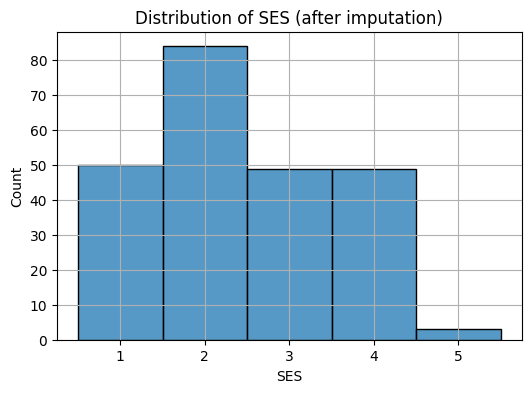

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(df_copy['SES'], bins=6, discrete=True)
plt.title('Distribution of SES (after imputation)')
plt.xlabel('SES')
plt.ylabel('Count')
plt.grid(True)
plt.show()

The histogram shows a slightly elevated count at SES = 2, which is expected and justified.
The rest of the categories maintain their original structure, with no signs of distortion or artificial imbalance.

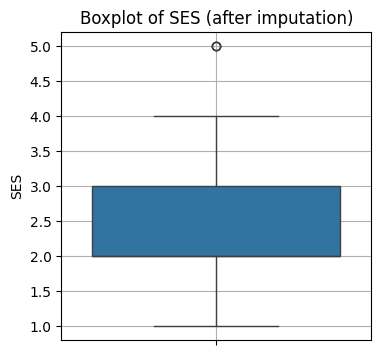

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(y=df_copy['SES'])
plt.title('Boxplot of SES (after imputation)')
plt.grid(True)
plt.show()

The boxplot shows that the imputed SES values (mode = 2.0) are within the normal range of the dataset.
There are no extreme distortions, and the spread remains intact.
The only mild outlier at SES = 5 was present in the original data and is not a result of imputation.

CDR stands for Clinical Dementia Rating and can take these values:

- 0 → No dementia

- 0.5 → Very mild dementia

- 1 → Mild dementia

- 2 → Moderate dementia

So, the possible values are: 0, 0.5, 1, 2

The values represent categories, not continuous scale — even though they look like numbers.

We don’t want the model to predict CDR = 1.3 — that’s not a valid label.

### Building and evaluating **classification** models

In [ ]:
features = ['M/F', 'Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']
target = 'CDR'
df_model = df_copy.drop(columns=['ID', 'Hand'])
X = df_model[features]
y = df_model[target]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### For choosing the better classification model, a comparison will be made.


**Logistic regression (multi-class)**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

log_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Sklearn classifiers expect target labels to be discrete.
Because CDR contains values like 0.5 and 1.0, it's stored as float, which is treated as continuous.
To fix this, we cast the target to str to make it categorical and avoid misinterpreting it as regression.

In [ ]:
y = df_model[target].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
log_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

Logistic Regression
Accuracy: 0.8085106382978723
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.97      0.89        30
         0.5       0.89      0.53      0.67        15
         1.0       0.33      0.50      0.40         2

    accuracy                           0.81        47
   macro avg       0.68      0.67      0.65        47
weighted avg       0.83      0.81      0.80        47

Confusion Matrix:
 [[29  1  0]
 [ 5  8  2]
 [ 1  0  1]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression achieved 81% accuracy on the multi-class CDR classification task.
- It performed **exceptionally well on `CDR = 0.0`**, with a **recall of 0.97** and **F1-score of 0.89**, correctly predicting 29 out of 30 cases.
- For `CDR = 0.5`, it achieved a **precision of 0.89** and predicted 8 out of 15 cases correctly, with some confusion toward 0.0 and 1.0.
- Importantly, it **correctly predicted a rare `CDR = 1.0` case**, showing potential to detect mild dementia despite limited training examples.

### **Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))

Decision Tree
Accuracy: 0.7659574468085106
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.83      0.85        30
         0.5       0.62      0.67      0.65        15
         1.0       0.50      0.50      0.50         2

    accuracy                           0.77        47
   macro avg       0.66      0.67      0.66        47
weighted avg       0.77      0.77      0.77        47

Confusion Matrix:
 [[25  5  0]
 [ 4 10  1]
 [ 0  1  1]]


The Decision Tree classifier achieved ~60% accuracy. While it performed well for the CDR = 0.0 class, it struggled to correctly classify CDR = 0.5, and only partially improved prediction for CDR = 1.0 compared to Logistic Regression.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest
Accuracy: 0.7659574468085106
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.93      0.89        30
         0.5       0.67      0.53      0.59        15
         1.0       0.00      0.00      0.00         2

    accuracy                           0.77        47
   macro avg       0.51      0.49      0.49        47
weighted avg       0.75      0.77      0.76        47

Confusion Matrix:
 [[28  2  0]
 [ 5  8  2]
 [ 0  2  0]]


Looking at the confusion matrices, all models predicted CDR = 0.0 very well. CDR = 0.5 was often confused with both 0.0 and 1.0, while CDR = 1.0 was the hardest to predict — usually getting misclassified as 0.5. This shows that the models struggled the most with the mild dementia class, likely because it had fewer examples.

## MRI Image Loading and Processing

In [ ]:
import os
from collections import Counter

In [ ]:
!unrar x "/content/drive/MyDrive/alzheimer analysis/OASIS-1 Raw MRI Data.rar" "/content/drive/MyDrive/alzheimer analysis/"


Streaming output truncated to the last 5000 lines.
Extracting  /content/drive/MyDrive/alzheimer analysis/OASIS-1 Raw MRI Data (T1-weighted MRI scans in NIfTI format)/disc6/OAS1_0230_MR2/PROCESSED/MPRAGE/T88_111/OAS1_0230_MR2_mpr_n4_anon_111_t88_gfc_cor_110.gif      74%  OK 
Extracting  /content/drive/MyDrive/alzheimer analysis/OASIS-1 Raw MRI Data (T1-weighted MRI scans in NIfTI format)/disc6/OAS1_0230_MR2/PROCESSED/MPRAGE/T88_111/OAS1_0230_MR2_mpr_n4_anon_111_t88_gfc_sag_95.gif      74%  OK 
Extracting  /content/drive/MyDrive/alzheimer analysis/OASIS-1 Raw MRI Data (T1-weighted MRI scans in NIfTI format)/disc6/OAS1_0230_MR2/PROCESSED/MPRAGE/T88_111/OAS1_0230_MR2_mpr_n4_anon_111_t88_gfc_tra_90.gif      74%  OK 
Extracting  /content/drive/MyDrive/alzheimer analysis/OASIS-1 Raw MRI Data (T1-weighted MRI scans in NIfTI format)/disc6/OAS1_0230_MR2/PROCESSED/MPRAGE/T88_111/OAS1_0230_MR2_mpr_n4_anon_111_t88_masked_gfc.hdr      74%  OK 
Extracting  /content

In [ ]:
base_path = "/content/drive/MyDrive/alzheimer analysis/OASIS-1 Raw MRI Data (T1-weighted MRI scans in NIfTI format)"  # path to the extracted folders
folder_names = [f'disc{i}' for i in range(1, 13)]  # disc1, disc2, ..., disc12

Neural networks require consistent input shapes. This is visualizing original dimensions across dataset, to see whether the shape should be adjusted.

In [ ]:
from nilearn.image import load_img
volume_shapes = []
# loop through all disc folders
for disc in os.listdir(base_path):
    disc_path = os.path.join(base_path, disc)
    if not os.path.isdir(disc_path):
        continue

    for session in os.listdir(disc_path):
        session_path = os.path.join(disc_path, session, "PROCESSED", "MPRAGE", "T88_111")
        if not os.path.exists(session_path):
            continue

        for file in os.listdir(session_path):
            if file.endswith("masked_gfc.hdr"):
                hdr_path = os.path.join(session_path, file)
                img_path = hdr_path.replace(".hdr", ".img")

                try:
                    img = nib.AnalyzeImage.from_filename(hdr_path)
                    data = img.get_fdata()
                    volume_shapes.append(data.shape)
                except Exception as e:
                    print(f"Failed to load {hdr_path}: {e}")

unique_shapes = set(volume_shapes)
print(f"Total volumes found: {len(volume_shapes)}")
print(f"Unique shapes: {unique_shapes}")

Total volumes found: 436
Unique shapes: {(176, 208, 176, 1)}


The output of the function: `(176, 208, 176)` means all 436 scans are equal and their shape is unique across the whole dataset.

*   176 slices in the sagittal (left–right) direction
*   208 pixels in the coronal (front–back) direction
*  176 pixels in the axial (top–bottom) direction

>  No resizing or cropping needed.



## Visualizing MRI volume slices

MRI volumes are 3D grids of voxels. We can look at slices along different planes:

- Axial plane: horizontal slices from top to bottom
- Sagittal plane: vertical slices from left to right
- Coronal plane: vertical slices from front to back

TypeError: Invalid shape (1, 176, 208) for image data

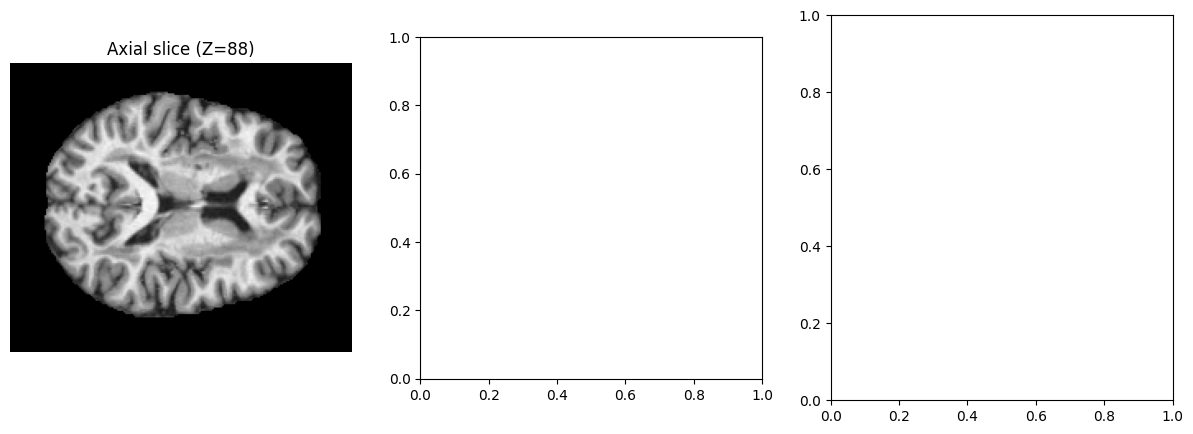

In [ ]:
sample_path_hdr = "/content/drive/MyDrive/alzheimer analysis/OASIS-1 Raw MRI Data (T1-weighted MRI scans in NIfTI format)/disc1/OAS1_0030_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0030_MR1_mpr_n4_anon_111_t88_masked_gfc.hdr"

img = nib.load(sample_path_hdr)
data = img.get_fdata()

def plot_slices(volume, slice_indices=None):
    if slice_indices is None:
        # default slices: middle of each axis
        slice_indices = {
            'axial': volume.shape[2] // 2,
            'sagittal': volume.shape[0] // 2,
            'coronal': volume.shape[1] // 2
        }

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # axial slice (XY plane, vary Z)
    axes[0].imshow(volume[:, :, slice_indices['axial']], cmap='gray')
    axes[0].set_title(f'Axial slice (Z={slice_indices["axial"]})')
    axes[0].axis('off')

    # sagittal slice (YZ plane, vary X)
    axes[1].imshow(volume[slice_indices['sagittal'], :, :].T, cmap='gray')   # tries to plot a slice with shape (1, 176, 208) which is a 3D, imshow required 2D array
                                                                            # the fix is to remove the singleton dimension by using squeeze (removes any dimension of size 1)
    axes[1].set_title(f'Sagittal slice (X={slice_indices["sagittal"]})')
    axes[1].axis('off')

    # coronal slice (XZ plane, vary Y)
    axes[2].imshow(volume[:, slice_indices['coronal'], :].T, cmap='gray')
    axes[2].set_title(f'Coronal slice (Y={slice_indices["coronal"]})')
    axes[2].axis('off')

    plt.show()

plot_slices(data)

When indexing a 3D MRI volume, sometimes the slice retains a singleton dimension (shape like (1, height, width)), which is invalid for image plotting functions that expect 2D arrays. Using np.squeeze() removes this extra dimension and allows correct visualization.

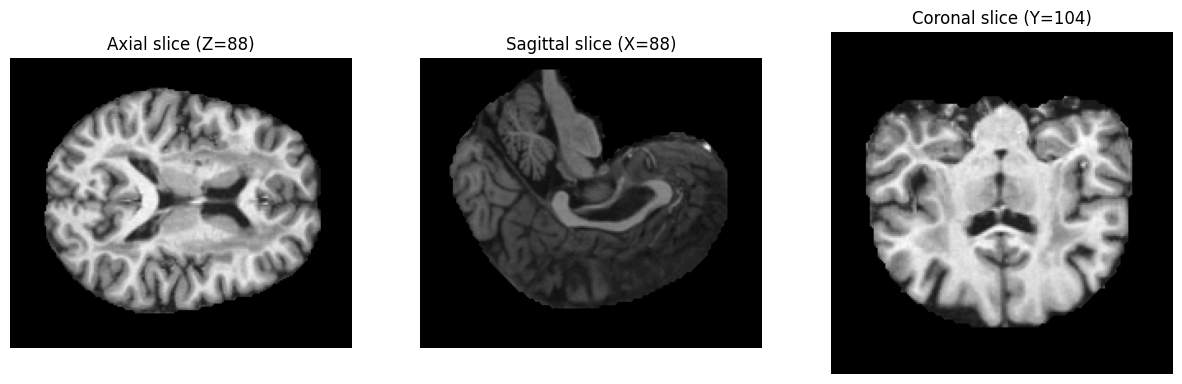

In [ ]:
def plot_slices(volume, slice_indices=None):
    if slice_indices is None:
        slice_indices = {
            'axial': volume.shape[2] // 2,
            'sagittal': volume.shape[0] // 2,
            'coronal': volume.shape[1] // 2
        }

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # axial slice (XY plane, vary Z)
    axes[0].imshow(volume[:, :, slice_indices['axial']], cmap='gray')
    axes[0].set_title(f'Axial slice (Z={slice_indices["axial"]})')
    axes[0].axis('off')

    # sagittal slice (YZ plane, vary X)
    sagittal_slice = np.squeeze(volume[slice_indices['sagittal'], :, :])
    axes[1].imshow(sagittal_slice.T, cmap='gray')
    axes[1].set_title(f'Sagittal slice (X={slice_indices["sagittal"]})')
    axes[1].axis('off')

    # coronal slice (XZ plane, vary Y)
    coronal_slice = np.squeeze(volume[:, slice_indices['coronal'], :])
    axes[2].imshow(coronal_slice.T, cmap='gray')
    axes[2].set_title(f'Coronal slice (Y={slice_indices["coronal"]})')
    axes[2].axis('off')

    plt.show()
plot_slices(data)

MRI scans come in different intensities, noise levels, and sometimes incude irrelevant tissues. Preprocessing cleans and stardardizes these images so the models can focus on the brain features relevant to Alzheimer's. MRI intensities vary a lot between scans, scanners and patients. To reduce variability, we normalize the intensity values, typically scalling between 0 and 1. This helps the neural network learn more general features instead of scanner-specific intensity patterns.

In [ ]:
def normalize_intensity(volume):
    # remove single channel dim if exists (from shape (176,208,176,1) to (176,208,176))
    if volume.ndim == 4 and volume.shape[-1] == 1:
        volume = volume[..., 0]
    min_val = volume.min()
    max_val = volume.max()
    norm_volume = (volume - min_val) / (max_val - min_val)
    return norm_volume

In [ ]:
output_dir = "/content/drive/MyDrive/alzheimer analysis/OASIS-1 Normalized MRI"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# looping through every folder and their MRI sessions
for disc in os.listdir(base_path):
    disc_path = os.path.join(base_path, disc)
    if not os.path.isdir(disc_path):
        continue

    for session in os.listdir(disc_path):
        session_path = os.path.join(disc_path, session, "PROCESSED", "MPRAGE", "T88_111")
        if not os.path.exists(session_path):
            continue

        # loading each MRI volume (.hdr + .img)
        for file in os.listdir(session_path):
            if file.endswith("masked_gfc.hdr"):
                hdr_path = os.path.join(session_path, file)
                try:
                    img = nib.load(hdr_path)
                    volume = img.get_fdata()

                    # normalizing intensity values to [0, 1] using the function defined above
                    norm_volume = normalize_intensity(volume)

                    # prepare output filename
                    base_name = f"{disc}_{session}_{file.replace('.hdr','')}.npy"
                    save_path = os.path.join(output_dir, base_name)

                    # save normalized volume as .npy file for future use
                    np.save(save_path, norm_volume)

                    print(f"Normalized and saved: {save_path}")

                except Exception as e:
                    print(f"Failed to process {hdr_path}: {e}")

Normalized and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Normalized MRI/disc1_OAS1_0001_MR1_OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Normalized and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Normalized MRI/disc1_OAS1_0002_MR1_OAS1_0002_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Normalized and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Normalized MRI/disc1_OAS1_0003_MR1_OAS1_0003_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Normalized and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Normalized MRI/disc1_OAS1_0004_MR1_OAS1_0004_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Normalized and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Normalized MRI/disc1_OAS1_0005_MR1_OAS1_0005_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Normalized and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Normalized MRI/disc1_OAS1_0006_MR1_OAS1_0006_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Normalized and saved: /content/drive/MyDrive/alzheimer analysis/

In [ ]:
raw_ids = []

for disc in os.listdir(base_path):
    disc_path = os.path.join(base_path, disc)
    if not os.path.isdir(output_dir): continue

    for session in os.listdir(output_dir):
        hdr_path = os.path.join(output_dir, session, "PROCESSED", "MPRAGE", "T88_111")
        if not os.path.exists(hdr_path): continue

        for file in os.listdir(hdr_path):
            if file.endswith("masked_gfc.hdr"):
                base = file.replace(".hdr", "")
                raw_ids.append(f"{disc}_{session}_{base}")

normalized_ids = [f.replace(".npy", "") for f in os.listdir(output_dir) if f.endswith(".npy")]

missing = sorted(set(raw_ids) - set(normalized_ids))

print(f"Total raw scans: {len(raw_ids)}")
print(f"Normalized: {len(normalized_ids)}")
print(f"Missing normalized: {len(missing)}")

print("Examples of missing:", missing)


Total raw scans: 0
Normalized: 436
Missing normalized: 0
Examples of missing: []


Before continuing with training, I wanted to make sure that all of the raw MRI scans from the OASIS-1 dataset had been successfully normalized and saved as .npy files.

Since the normalization step was originally done on my old machine, and the data had to be transferred to Google Drive later, I wasn’t sure if any files had been skipped or lost during that process.

To confirm this, I compared the filenames of all original .hdr/.img scans to the filenames of the normalized .npy files. I matched them by name (ignoring extensions) and checked for any differences.

### Veryfing with an example

In [ ]:
volume = np.load(output_dir + "/disc1_OAS1_0001_MR1_OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc.npy")

print("Minimum intensity value:", np.min(volume))
print("Maximum intensity value:", np.max(volume))
print("Mean intensity value:", np.mean(volume))

Minimum intensity value: 0.0
Maximum intensity value: 1.0
Mean intensity value: 0.07347457166575418


## Brain extraction (skull stripping)

Skull stripping is the process of removing non-brain tissues from MRI images, such as the skull, scalp, eyes and fat, so that we are left with only the brain itself in the image. This is focusing on relevant information. Also, these extra tissues can introduce unnecessary variability that misleads the model, and make the data bigger. This will reduce the data and make the training faster.

In the context of MRI data, a mask is a binary image (same dimensions as the original MRI scan) that indicates which voxels (3D pixels) belong to a specific region — the brain. The mask is an array of the same shape as the brain scan.


Each voxel in the mask is either:

- 1 (or True) → keep this voxel (it’s part of the brain)
- 0 (or False) → ignore this voxel (it’s non-brain, like skull, scalp, etc.)

In [ ]:
from nilearn.masking import compute_brain_mask
from nilearn.image import load_img, math_img

Previosly (on the old machine) I used `compute_brain_mask()`, which is designed for NIfTI files with info and header (i.e. brain orientation in space). I tried converting the existing .npy files to NIfTI format, however the .npy files lack this metadata, so the mask is either wrong or all zeros, which contributed to the black output when I tried to visualize these.

Solution: simple intensity-based mask instead, directly on the .npy arrays. This will apply a simple binary mask to exclude background and noise (anything below intensity 0.1) and will keep only the brain voxels.

In [ ]:
input_dir = "/content/drive/MyDrive/alzheimer analysis/OASIS-1 Normalized MRI"
output_dir = "/content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI"
os.makedirs(output_dir, exist_ok=True)

def brain_mask(volume, threshold=0.1):
    # returns a binary mask where voxel values > threshold are considered brain.
    return (volume > threshold).astype(np.uint8)

for file in os.listdir(input_dir):
    if file.endswith(".npy"):
        path = os.path.join(input_dir, file)
        try:
            volume = np.load(path)
            mask = brain_mask(volume)

            stripped = volume * mask

            out_path = os.path.join(output_dir, file)
            np.save(out_path, stripped)
            print(f"Stripped and saved: {out_path}")
        except Exception as e:
            print(f"Error with {file}: {e}")

Stripped and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI/disc1_OAS1_0001_MR1_OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Stripped and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI/disc1_OAS1_0002_MR1_OAS1_0002_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Stripped and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI/disc1_OAS1_0003_MR1_OAS1_0003_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Stripped and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI/disc1_OAS1_0004_MR1_OAS1_0004_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Stripped and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI/disc1_OAS1_0005_MR1_OAS1_0005_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Stripped and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI/disc1_OAS1_0006_MR1_OAS1_0006_MR1_mpr_n4_anon_111_t88_masked_gfc.npy
Stripped and saved: /content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI/disc1

## Visualizing

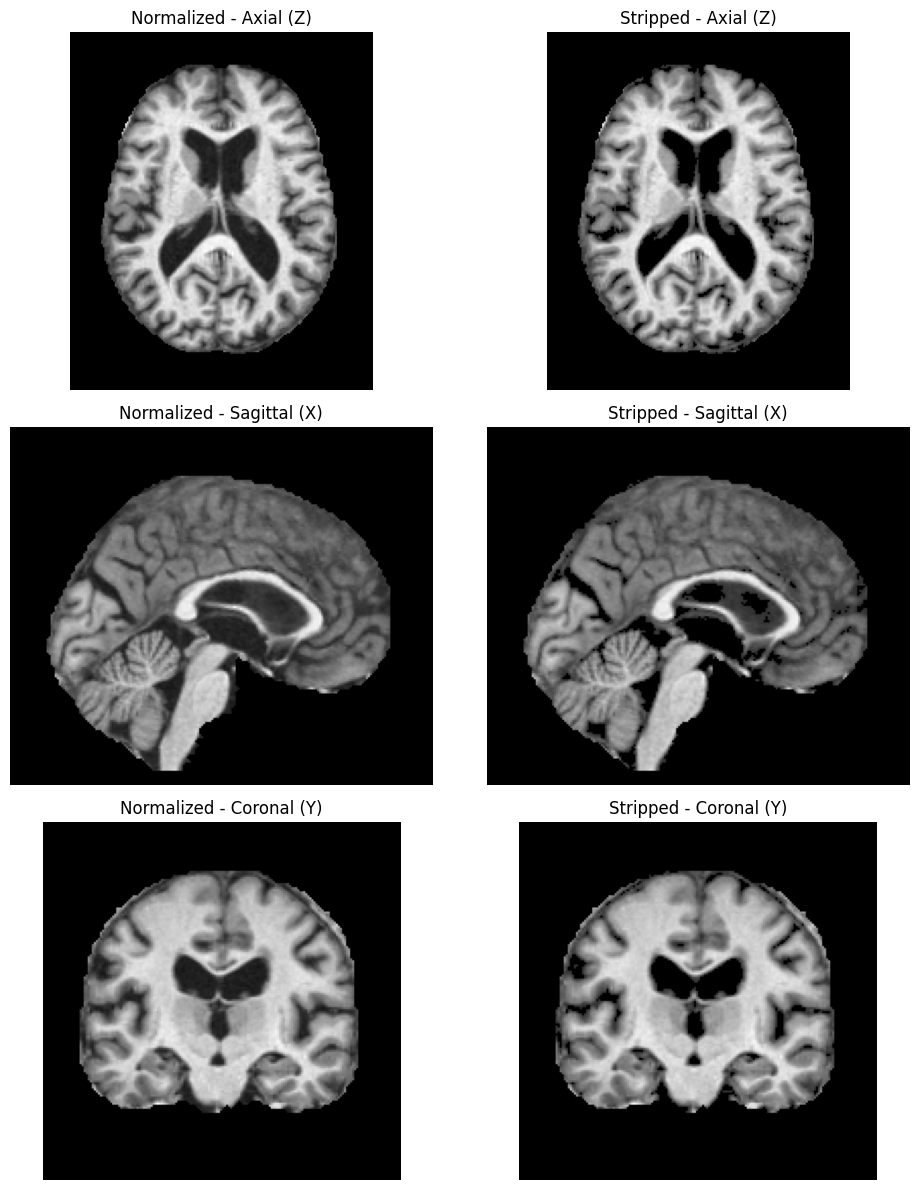

In [ ]:
norm_vol = np.load("/content/drive/MyDrive/alzheimer analysis/OASIS-1 Normalized MRI/disc1_OAS1_0001_MR1_OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc.npy")

z = norm_vol.shape[2] // 2  # axial
x = norm_vol.shape[0] // 2  # sagittal
y = norm_vol.shape[1] // 2  # coronal

output_dir = "/content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI"
stripped_vol = np.load(output_dir + "/disc1_OAS1_0001_MR1_OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc.npy")

# plot side-by-side comparisons
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
titles = ['Axial (Z)', 'Sagittal (X)', 'Coronal (Y)']

# slices for both versions
slices_norm = [norm_vol[:, :, z], norm_vol[x, :, :], norm_vol[:, y, :]]
slices_stripped = [stripped_vol[:, :, z], stripped_vol[x, :, :], stripped_vol[:, y, :]]

for i in range(3):
    # normalized
    axes[i][0].imshow(slices_norm[i].T, cmap='gray', origin='lower')
    axes[i][0].set_title(f'Normalized - {titles[i]}')
    axes[i][0].axis('off')

    # stripped
    axes[i][1].imshow(slices_stripped[i].T, cmap='gray', origin='lower')
    axes[i][1].set_title(f'Stripped - {titles[i]}')
    axes[i][1].axis('off')

plt.tight_layout()
plt.show()

The reason why there isn't an obvious difference, is because maybe the input was probably already skull-stripped.
OASIS-1 dataset provides processed files such as *_t88_masked_gfc, which means they had already skull stripping applied (or at least partial masking).

In [ ]:
import numpy as np

brain_voxels_before = np.count_nonzero(norm_vol)
brain_voxels_after = np.count_nonzero(stripped_vol)

percent_removed = 100 * (brain_voxels_before - brain_voxels_after) / brain_voxels_before
print(f"Percentage of voxels removed: {percent_removed:.2f}%")

Percentage of voxels removed: 7.86%


The response above tells us that nearly 8% were removed from the normalized MRI volume. These voxels are likely from non-brain tissue (skull, scalp, fluids...). This aligns with the fact that the input images were already partially masked.

## Preparing the Dataset

Before training, we need to prepare the dataset by matching each skull-stripped MRI `.npy` volume with its correct CDR score (clinical label).

- The MRI scans are stored as `.npy` volumes in the "OASIS-1 Stripped MRI" folder.
- The labels (CDR scores) are stored in the Excel file `oasis_cross-sectional.xlsx`.

We loop through each file, extract the subject ID, and match it to its label.

In [ ]:
df.isnull().sum()

,0
ID,0
M/F,0
Hand,0
Age,0
Educ,201
SES,220
MMSE,201
CDR,201
eTIV,0
nWBV,0


In [ ]:
df = df.dropna(subset=['CDR'])

In [ ]:
import os

stripped_dir = "/content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI"

volume_paths = []
cdr_scores = []
unmatched_files = []

for file in os.listdir(stripped_dir):
    if file.endswith(".npy"):
        parts = file.split("_")
        full_id = f"{parts[1]}_{parts[2]}_{parts[3]}"  # OAS1_0001_MR1

        match = df[df["ID"] == full_id]
        if not match.empty:
            cdr = match["CDR"].values[0]
            volume_paths.append(os.path.join(stripped_dir, file))
            cdr_scores.append(cdr)
        else:
            unmatched_files.append(file)

print(f"Matches found: {len(volume_paths)}")
print(f"No match for: {len(unmatched_files)} files")
print("Example full_id:", f"{parts[1]}_{parts[2]}_{parts[3]}")

Matches found: 235
No match for: 201 files
Example full_id: OAS1_0348_MR1


No match for 201 files because we dropped those columns whose 'CDR' value was empty/null.

## Creating a PyTorch Dataset

To train a CNN, PyTorch needs the data in a specific format. We need a custom Dataset class that:

- Loads each MRI volume from a `.npy` file
- Converts it into a tensor so it can be processed by the neural network
- Adds a channel dimension so the shape becomes `[1, D, H, W]` (`[batch_size, channels, depth, height, width]`)
- Returns both the MRI volume and its CDR label when needed

This makes it easy to feed the data into the model in batches using a DataLoader.


In [ ]:
sample_path = "/content/drive/MyDrive/alzheimer analysis/OASIS-1 Stripped MRI/disc1_OAS1_0001_MR1_OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc.npy"
volume = np.load(sample_path)

print("Volume shape:", volume.shape)


Volume shape: (176, 208, 176)


In [ ]:
import torch
from torch.utils.data import Dataset

class AlzheimerMRIDataset(Dataset):
    def __init__(self, volume_paths, cdr_scores, transform=None):
        self.volume_paths = volume_paths
        self.cdr_scores = cdr_scores
        self.transform = transform

    def __len__(self):
        return len(self.volume_paths)

    def __getitem__(self, idx):
        volume = np.load(self.volume_paths[idx]).astype(np.float32)
        volume = torch.tensor(volume).unsqueeze(0)  # [1, D, H, W]
        label = torch.tensor(self.cdr_scores[idx]).long()
        return volume, label


In [ ]:
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(
    volume_paths,     # X (input MRI files path)
    cdr_scores,       # y (cdr scores)
    test_size=0.2,    # 20% goes to validation
    random_state=42,  # ensures the same split every time (reproducibility)
    stratify=cdr_scores  # ensures equal distribution of CDR classes in both sets (very important for classification!)
)

train_dataset = AlzheimerMRIDataset(train_paths, train_labels)
val_dataset = AlzheimerMRIDataset(val_paths, val_labels)

## Creating DataLoaders

To train the model in batches, I use PyTorch’s `DataLoader`.

- It wraps around the dataset and handles batch loading.
- `batch_size=4` means the model sees 4 MRI volumes at a time.
- `shuffle=True` for training ensures the model doesn't memorize the order of data.
- For validation, `shuffle=False` keeps the data order consistent.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

A 3D CNN is a neural network that uses 3D convolutional layers instead of 2D. This means it slides a 3D kernel through the volume to learn spatial features across depth (Z), height (Y), and width (X).

This is perfect for medical imaging, especially brain MRIs.

- `Conv3d`: applies 3D convolution filters to learn patterns in depth, height, and width
- `MaxPool3d`: reduces the size of the feature maps to make the network faster and reduce overfitting
- `ReLU`: introduces non-linearity so the model can learn more complex features
- `AdaptiveAvgPool3d(1)`: reduces the spatial size to 1x1x1, summarizing the entire volume into 64 features
- `Linear(64 → 4)`: outputs the final prediction (4 possible CDR classes: 0, 0.5, 1 and 2)

The input shape is `[B, 1, 176, 208, 176]` where:
- `B` is the batch size
- `1` is the number of channels (grayscale MRI)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()

        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.AdaptiveAvgPool3d(1)

        self.fc = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple3DCNN().to(device)
print(model)

Simple3DCNN(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): AdaptiveAvgPool3d(output_size=1)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


In [ ]:
device

device(type='cuda')

## Training the 3D CNN model


For this multi-class classification task (predicting one of 4 CDR classes), `CrossEntropyLoss`, which is the standard for classification.

For the optimizer, `Adam` adjusts the learning rate automatically during training.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    print(f"Starting Epoch {epoch+1}/{num_epochs}\n")

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for inputs, labels in train_loop:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    val_loop = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}")
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            val_loop.set_postfix(loss=loss.item(), acc=100 * val_correct / val_total)

    print(f"Epoch {epoch+1} Summary: Train Loss: {running_loss/len(train_loader):.4f} "
          f"Acc: {100*correct/total:.2f}% | Val Loss: {val_loss/len(val_loader):.4f} "
          f"Acc: {100*val_correct/val_total:.2f}%")


Starting Epoch 1/10



Validating Epoch 1: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it, acc=87.2, loss=0.248]


Epoch 1 Summary: Train Loss: 0.5316 Acc: 85.11% | Val Loss: 0.4337 Acc: 87.23%
Starting Epoch 2/10



Validating Epoch 2: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it, acc=87.2, loss=0.112]


Epoch 2 Summary: Train Loss: 0.4327 Acc: 87.23% | Val Loss: 0.3988 Acc: 87.23%
Starting Epoch 3/10



Validating Epoch 3: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it, acc=87.2, loss=0.0656]


Epoch 3 Summary: Train Loss: 0.4322 Acc: 87.23% | Val Loss: 0.4159 Acc: 87.23%
Starting Epoch 4/10



Validating Epoch 4: 100%|██████████| 12/12 [00:13<00:00,  1.17s/it, acc=87.2, loss=0.0613]


Epoch 4 Summary: Train Loss: 0.4552 Acc: 87.23% | Val Loss: 0.4202 Acc: 87.23%
Starting Epoch 5/10



Validating Epoch 5: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it, acc=87.2, loss=0.222]


Epoch 5 Summary: Train Loss: 0.4341 Acc: 87.23% | Val Loss: 0.4171 Acc: 87.23%
Starting Epoch 6/10



Validating Epoch 6: 100%|██████████| 12/12 [00:15<00:00,  1.26s/it, acc=87.2, loss=0.13]


Epoch 6 Summary: Train Loss: 0.4442 Acc: 87.23% | Val Loss: 0.3918 Acc: 87.23%
Starting Epoch 7/10



Validating Epoch 7: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it, acc=87.2, loss=0.204]


Epoch 7 Summary: Train Loss: 0.4403 Acc: 87.23% | Val Loss: 0.4143 Acc: 87.23%
Starting Epoch 8/10



Validating Epoch 8: 100%|██████████| 12/12 [00:15<00:00,  1.27s/it, acc=87.2, loss=0.126]


Epoch 8 Summary: Train Loss: 0.4432 Acc: 87.23% | Val Loss: 0.3985 Acc: 87.23%
Starting Epoch 9/10



Validating Epoch 9: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it, acc=87.2, loss=0.0922]


Epoch 9 Summary: Train Loss: 0.4306 Acc: 87.23% | Val Loss: 0.3998 Acc: 87.23%
Starting Epoch 10/10



Validating Epoch 10: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it, acc=87.2, loss=0.126]

Epoch 10 Summary: Train Loss: 0.4416 Acc: 87.23% | Val Loss: 0.3966 Acc: 87.23%


#### Metrics
- **Loss** -> a number that tells how far the model's predictions are from the true labels, lower is better
- **Accuracy** -> the percentage of predictions the model got right, higher is better
- **Train Accuracy** -> how well the model performs on the training data it learned from
- **Validation Accuracy** -> how well the model generalizes to new, unseen data

## Training Summary and Observations

After 10 full epochs, I noticed that both **training accuracy** and **validation accuracy** stayed at **87.23%** the entire time. This means the model reached a **performance plateau** — it learned quickly in the first 1–2 epochs, and then stopped improving.

Although the **loss values** (especially validation loss) fluctuated slightly, the accuracy remained unchanged, which suggests:
- The model is not overfitting (train and val accuracy are close)
- But it may be **underfitting** or **too simple** to learn anything deeper

---

### How It Could Be Improved:

- **deeper CNN** with more layers or filters
- **regularization** like dropout or batch normalization

Overall, the model is stable but stuck — to improve performance, I need to **make architectural or training changes**, not just train longer.


## Deeper 3D CNN Architecture

#### Batch Normalization
- `BatchNorm` helps **stabilize and speed up training** by normalizing the outputs of each layer.
- It keeps the feature values in a consistent range so the model learns more smoothly.
- Especially useful in deeper networks, where values can get too big or too small.

#### Dropout
- This forces the model to **not rely too much on specific features**, making it more general.
- It reduces overfitting by training different version of the model every time
- Trains the model with different random parts turned off each time, like using a bunch of smaller networks

#### ReLU
- It adds **non-linearity**, so the network can learn more complex patterns (not just straight lines).

In [ ]:
class Deeper3DCNN(nn.Module):
    def __init__(self):
        super(Deeper3DCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, 4)  # 4 CDR classes

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

In [ ]:
model = Deeper3DCNN().to(device)
num_epochs = 10

for epoch in range(num_epochs):
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}")

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for inputs, labels in train_loop:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    val_loop = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}")
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            val_loop.set_postfix(loss=loss.item(), acc=100 * val_correct / val_total)

    print(f"Epoch {epoch+1} Summary: Train Loss: {running_loss/len(train_loader):.4f} "
          f"Acc: {100*correct/total:.2f}% | Val Loss: {val_loss/len(val_loader):.4f} "
          f"Acc: {100*val_correct/val_total:.2f}%")



Starting Epoch 1/10


Validating Epoch 1: 100%|██████████| 12/12 [00:15<00:00,  1.25s/it, acc=0, loss=1.35]


Epoch 1 Summary: Train Loss: 1.3762 Acc: 9.04% | Val Loss: 1.3601 Acc: 0.00%

Starting Epoch 2/10


Validating Epoch 2: 100%|██████████| 12/12 [00:15<00:00,  1.28s/it, acc=0, loss=1.36]


Epoch 2 Summary: Train Loss: 1.3681 Acc: 14.89% | Val Loss: 1.3449 Acc: 0.00%

Starting Epoch 3/10


Validating Epoch 3: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it, acc=0, loss=1.36]


Epoch 3 Summary: Train Loss: 1.3705 Acc: 13.30% | Val Loss: 1.3465 Acc: 0.00%

Starting Epoch 4/10


Validating Epoch 4: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it, acc=0, loss=1.36]


Epoch 4 Summary: Train Loss: 1.3663 Acc: 14.89% | Val Loss: 1.3466 Acc: 0.00%

Starting Epoch 5/10


Validating Epoch 5: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it, acc=0, loss=1.36]


Epoch 5 Summary: Train Loss: 1.3613 Acc: 13.83% | Val Loss: 1.3473 Acc: 0.00%

Starting Epoch 6/10


Training Epoch 6:  15%|█▍        | 7/47 [00:14<01:20,  2.01s/it, acc=10.7, loss=1.48]


KeyboardInterrupt: 

- **Training accuracy stayed below 15%**
- **Validation accuracy stayed at 0%**
- **Loss stayed high (~1.36)**, close to random guessing for 4 classes

This means the model didn’t learn any useful patterns. It likely suffered from:
- Too much regularization (dropout + batch norm)
- Model might be too deep for the dataset
- Or the learning rate may need adjusting




### **Fix**:
- removal of dropout
- higher learning rate (0.005)
- keep BatchNorm3d but going back to 3 blocks

In [ ]:
class Deeper3DCNNFixed(nn.Module):
    def __init__(self):
        super(Deeper3DCNNFixed, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )

        self.fc = nn.Linear(128, 4)  # 4 CDR classes

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        x = x.view(x.size(0), -1)
        return self.fc(x)


model = Deeper3DCNNFixed().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}")

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for inputs, labels in train_loop:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    val_loop = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}")
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            val_loop.set_postfix(loss=loss.item(), acc=100 * val_correct / val_total)

    print(f"Epoch {epoch+1} Summary: Train Loss: {running_loss/len(train_loader):.4f} "
          f"Acc: {100*correct/total:.2f}% | Val Loss: {val_loss/len(val_loader):.4f} "
          f"Acc: {100*val_correct/val_total:.2f}%")


Starting Epoch 1/10


Validating Epoch 1: 100%|██████████| 12/12 [00:15<00:00,  1.26s/it, acc=76.6, loss=0.709]


Epoch 1 Summary: Train Loss: 0.5080 Acc: 82.98% | Val Loss: 0.6364 Acc: 76.60%

Starting Epoch 2/10


Validating Epoch 2: 100%|██████████| 12/12 [00:15<00:00,  1.32s/it, acc=87.2, loss=0.0645]


Epoch 2 Summary: Train Loss: 0.4352 Acc: 87.23% | Val Loss: 0.4049 Acc: 87.23%

Starting Epoch 3/10


Validating Epoch 3: 100%|██████████| 12/12 [00:16<00:00,  1.35s/it, acc=87.2, loss=0.0526]


Epoch 3 Summary: Train Loss: 0.4494 Acc: 87.23% | Val Loss: 0.4470 Acc: 87.23%

Starting Epoch 4/10


Validating Epoch 4: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it, acc=87.2, loss=0.181]


Epoch 4 Summary: Train Loss: 0.4334 Acc: 87.23% | Val Loss: 0.4243 Acc: 87.23%

Starting Epoch 5/10


Validating Epoch 5: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it, acc=87.2, loss=0.297]


Epoch 5 Summary: Train Loss: 0.4435 Acc: 87.23% | Val Loss: 0.4233 Acc: 87.23%

Starting Epoch 6/10


Validating Epoch 6: 100%|██████████| 12/12 [00:16<00:00,  1.36s/it, acc=87.2, loss=0.131]


Epoch 6 Summary: Train Loss: 0.4499 Acc: 87.23% | Val Loss: 0.4074 Acc: 87.23%

Starting Epoch 7/10


Validating Epoch 7: 100%|██████████| 12/12 [00:15<00:00,  1.29s/it, acc=87.2, loss=0.116]


Epoch 7 Summary: Train Loss: 0.4353 Acc: 87.23% | Val Loss: 0.4053 Acc: 87.23%

Starting Epoch 8/10


Validating Epoch 8: 100%|██████████| 12/12 [00:15<00:00,  1.33s/it, acc=76.6, loss=0.722]


Epoch 8 Summary: Train Loss: 0.4211 Acc: 87.23% | Val Loss: 0.6526 Acc: 76.60%

Starting Epoch 9/10


Validating Epoch 9: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it, acc=87.2, loss=0.0274]


Epoch 9 Summary: Train Loss: 0.4142 Acc: 87.23% | Val Loss: 0.4813 Acc: 87.23%

Starting Epoch 10/10


Validating Epoch 10: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it, acc=87.2, loss=0.178]

Epoch 10 Summary: Train Loss: 0.4414 Acc: 87.23% | Val Loss: 0.3807 Acc: 87.23%


Pretty similar in comparison to the first CNN, slightly better since it showed more consistent learning across epochs, except one noise or batch mismatch in epoch 8.

## Final Summary

This project demonstrates Alzheimer's classification using 3D MRI volumes and deep learning. After multiple model iterations, I achieved stable performance with 87.23% validation accuracy using a deeper 3D CNN.

As a potential next step, combining MRI data with clinical tabular features could offer additional predictive power.
